#### Import the libraries

In [3]:
import tensorflow as tf 
from keras.layers import *
from keras.models import Model
from keras.datasets import imdb

#### Load the dataset

In [5]:
vocab_size = 20000
(x_train, y_train),(x_test, y_test) = imdb.load_data(num_words=vocab_size)

In [6]:
x_train.shape

(25000,)

In [7]:
x_test.shape

(25000,)

#### Define hyperparameters

In [9]:
maxlen = 200
embed_dim = 32
num_head = 2
ff_dim = 32

#### Data Preprocessing

In [11]:
from keras.preprocessing.sequence import pad_sequences

In [13]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [14]:
x_train.shape

(25000, 200)

In [16]:
x_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     1,   194,  1153,   194,  8255,    78,   228,
           5,     6,  1463,  4369,  5012,   134,    26,     4,   715,
           8,   118,  1634,    14,   394,    20,    13,   119,   954,
         189,   102,     5,   207,   110,  3103,    21,    14,    69,
         188,     8,    30,    23,     7,     4,   249,   126,    93,
           4,   114,     9,  2300,  1523,     5,   647,     4,   116,
           9,    35,  8163,     4,   229,     9,   340,  1322,     4,
         118,     9,     4,   130,  4901,    19,     4,  1002,     5,
          89,    29,   952,    46,    37,     4,   455,     9,    45,
          43,    38,  1543,  1905,   398,     4,  1649,    26,  6853,
           5,   163,    11,  3215, 10156,     4,  1153,     9,   194,
         775,     7,  8255, 11596,   349,  2637,   148,   605, 15358,
        8003,    15,   123,   125,    68,     2,  6853,    15,   349,
         165,  4362,

#### Build the model

In [19]:
# Input layer 
inputs = Input(shape=(maxlen,))

# Token Embedding Layer
token_emb_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)
x = token_emb_layer(inputs)

# Position Enbedding Layer 
positions = tf.range(0, maxlen)
pos_emb_layer = Embedding(input_dim=maxlen, output_dim=embed_dim)
positions_emb = pos_emb_layer(positions)

# Add the token + position embedding 
x = x + positions_emb

# Add transformer block 
# 1. Multi-head self Attention 
attention_output = MultiHeadAttention(
    num_heads=num_head, key_dim=embed_dim) (x, x)

attention_output = Dropout(0.1) (attention_output)

# Residual connections (add + norm) 
x1 = LayerNormalization() (x + attention_output)

# Feed-forward neural network 
ffn = Dense(ff_dim, activation='relu')(x1)
ffn = Dense(embed_dim)(ffn)
ffn = Dropout(0.1) (ffn)

# Residual connections (add + norm) 
x2 = LayerNormalization() (x1 + ffn)

# Classification Head 
x3 = GlobalAveragePooling1D()(x2)
x3 = Dropout(0.1) (x3)
x3 = Dense(20, activation='relu') (x3)
x3 = Dropout(0.1) (x3)

# Output layer 
outputs = Dense(1, activation='sigmoid')(x3)

In [20]:
# Create object of model 
model = Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 32)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 32)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 32)   │      8,416 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 32)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 32)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 32)   │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 32)   │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 32)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 32)   │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        660 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 651,337 (2.48 MB)

 Trainable params: 651,337 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from keras.utils import plot_model

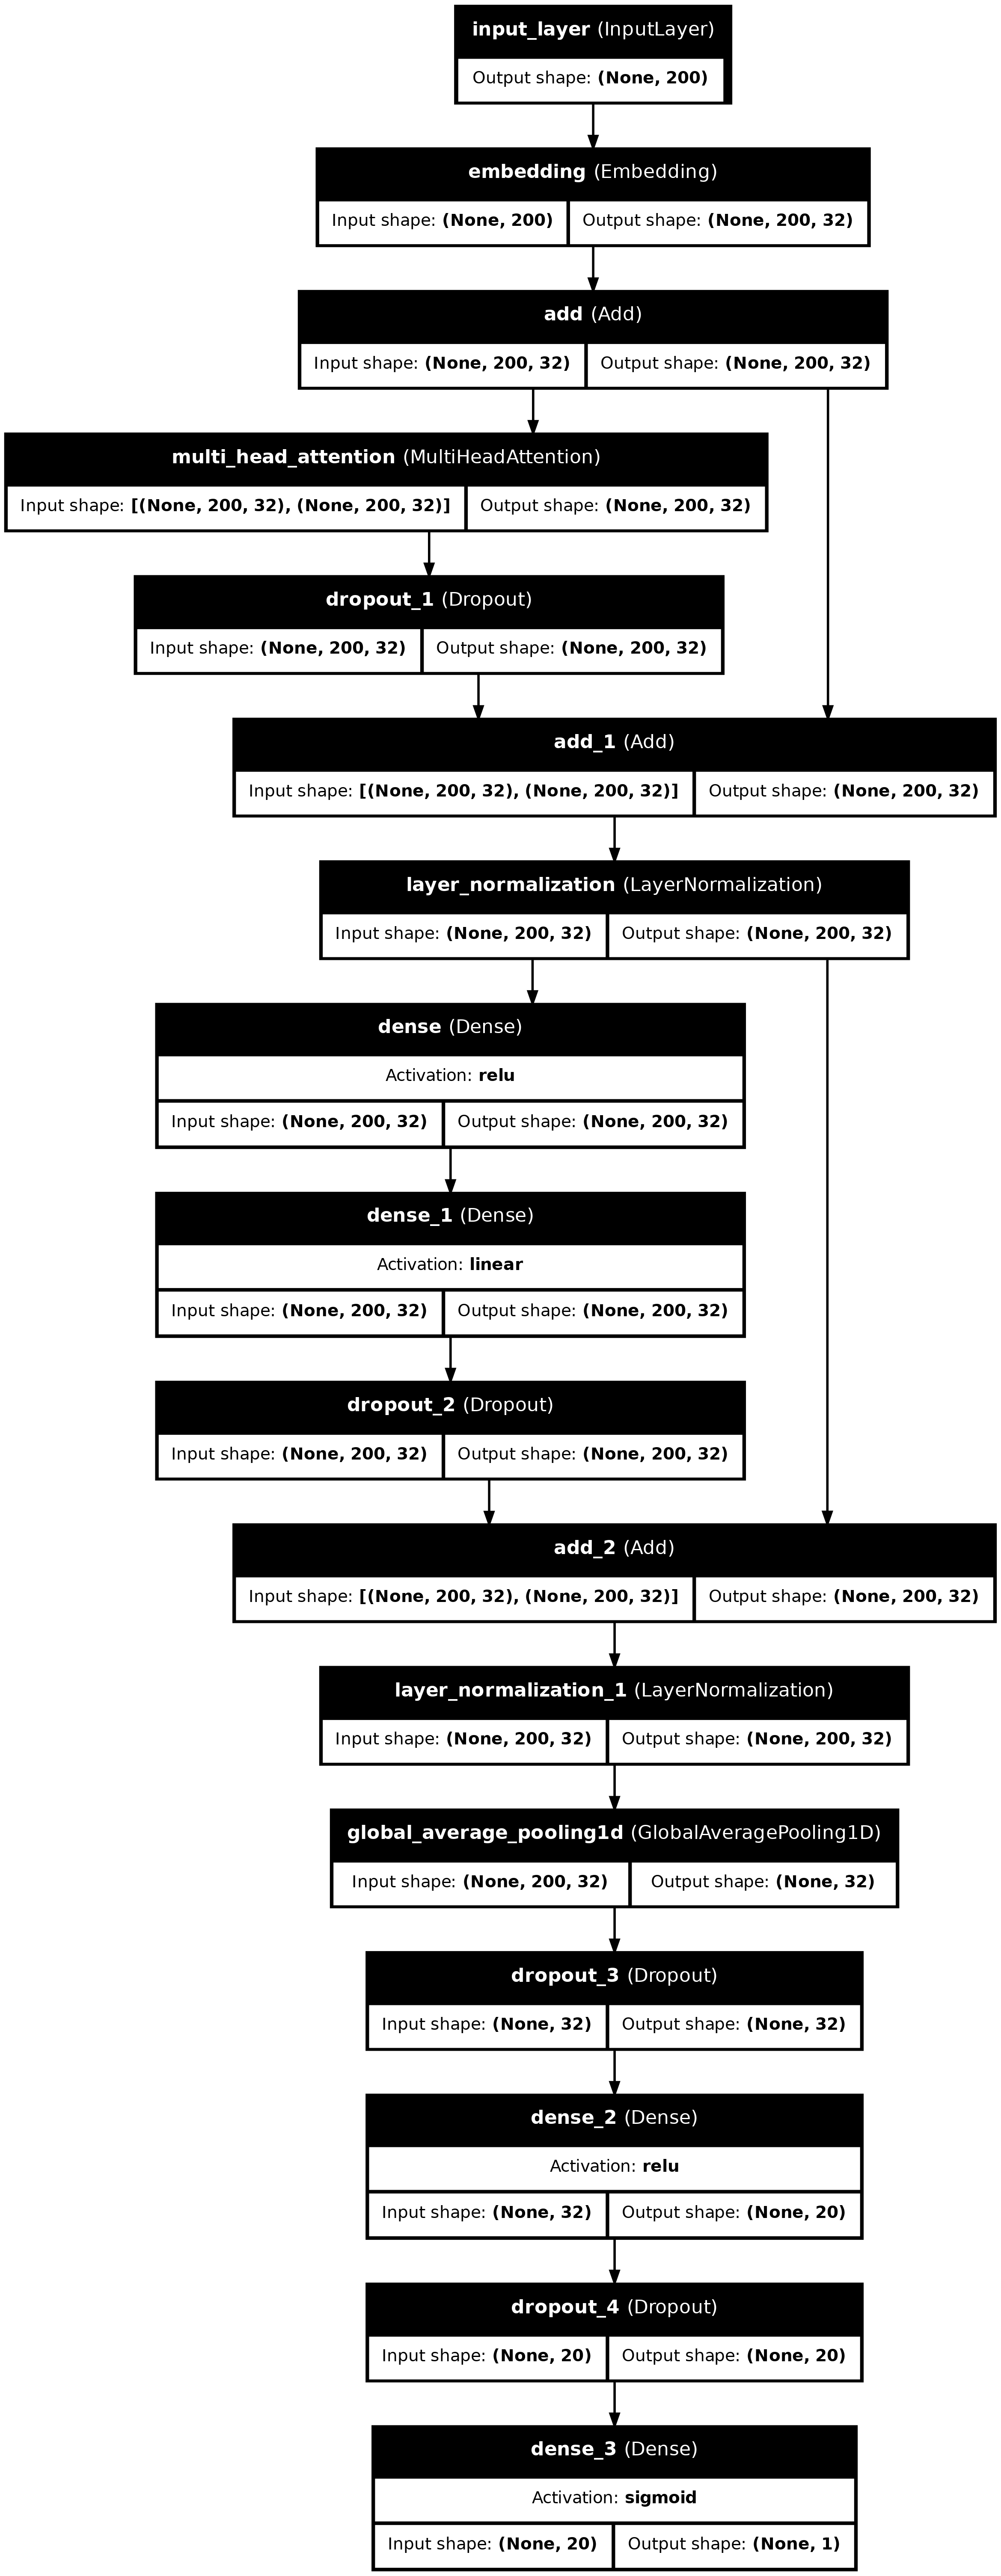

In [24]:
plot_model(model, show_layer_names=True, show_layer_activations=True,
          show_shapes=True)

In [25]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [26]:
# Train the model 
history = model.fit(x_train, y_train, batch_size=32,
                   epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.7133 - loss: 0.5210 - val_accuracy: 0.8803 - val_loss: 0.2891
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9278 - loss: 0.1962 - val_accuracy: 0.8654 - val_loss: 0.3156
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9618 - loss: 0.1131 - val_accuracy: 0.8520 - val_loss: 0.4076
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9806 - loss: 0.0659 - val_accuracy: 0.8382 - val_loss: 0.4984
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.9866 - loss: 0.0449 - val_accuracy: 0.8446 - val_loss: 0.5967


In [29]:
import numpy as np 

In [50]:
new = x_test[800]

In [51]:
new = np.reshape(new,(1, maxlen))

In [52]:
new.shape

(1, 200)

In [53]:
model.predict(new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.9991296]], dtype=float32)